## Imports

In [1]:
# TDastro libraries
import lsdb  # To get Rubin data

from tdastro.astro_utils.mag_flux import flux2mag, mag2flux  # AB mags <-> nJy
from tdastro.astro_utils.passbands import PassbandGroup  # Filter transmissions
from tdastro.base_models import FunctionNode  # Define custom parameter samplers
from tdastro.math_nodes.np_random import NumpyRandomFunc  # Parameter sampling with numpy.random
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler  # Sky position sampling
from tdastro.opsim.opsim import OpSim  # Deal with LSST cadence and noise simulations
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.lightcurve_source import LightcurveSource  # Source model

In [2]:
# pyLIMA libraries
from pyLIMA.simulations import simulator
from pyLIMA import event, toolbox
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model
from pyLIMA.outputs import pyLIMA_plots
import pyLIMA.fits.objective_functions
from pyLIMA.toolbox import fake_telescopes, plots, brightness_transformation

In [3]:
# Other packages
import matplotlib.pyplot as plt  # For plots
import numpy as np  # For math
import pandas as pd  # For tabular data

from astropy import units as u
from astropy.coordinates import SkyCoord

## Create a model with pyLIMA

In [4]:
# Hard-coded coordinates of the event
Ra, Dec = 270.66679, -35.70483 #OGLE-2024-BLG-0034 

# Long-duration microlensing event
event_parameters = {'t0': 2462100.0, 
                    'u0': 0.1, 
                    'tE': 270.0, 
                    'piEN': 0.01, 
                    'piEE': 0.04
                   }

# Target coordinates, OGLE-2024-BLG-0034
target = SkyCoord(Ra, Dec,
                  frame='icrs',
                  unit=(u.deg, u.deg))

# Target magnitudes for an event (hard-coded for now)
# they can be taken from TRILEGAL for a more realistic source
target_mag = {'u': 23., 'g': 22., 'r': 21.5, 'i': 21., 'z': 20.5, 'y': 19.5}

# Photometric zeropoint
ZP = pyLIMA.toolbox.brightness_transformation.ZERO_POINT
print('Photometric zeropoint in use = ' + str(ZP) + ' mag')

Photometric zeropoint in use = 27.4 mag


In [5]:
# I will simulate an ideal light curve for this event
time_grid = np.arange(0, 10000., 0.1)
# Adding a constant shift to simulate parallax properly
time_grid += 2460500.0

In [6]:
# Simulating telescopes
LSST_id_u = simulator.simulate_a_telescope(name='u', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

LSST_id_g = simulator.simulate_a_telescope(name='g', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

LSST_id_r = simulator.simulate_a_telescope(name='r', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

LSST_id_i = simulator.simulate_a_telescope(name='i', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

LSST_id_z = simulator.simulate_a_telescope(name='z', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

LSST_id_y = simulator.simulate_a_telescope(name='y', 
                                        location='Earth',
                                        timestamps=time_grid,
                                        astrometry=False)

In [7]:
# Creating a pyLIMA event and adding simulated telescopes
ra = target.ra.deg
dec = target.dec.deg

sim_event = event.Event(ra=ra, dec=dec)
# sim_event = event.Event()

sim_event.telescopes.append(LSST_id_u)
sim_event.telescopes.append(LSST_id_g)
sim_event.telescopes.append(LSST_id_r)
sim_event.telescopes.append(LSST_id_i)
sim_event.telescopes.append(LSST_id_z)
sim_event.telescopes.append(LSST_id_y)

In [8]:
# I will shift my event to the i-band
sim_event.find_survey('i')

# I chose a simple model here, but it can be changed
# to whatever pyLIMA supports
event_model = PSPL_model.PSPLmodel(sim_event,
                                   parallax=['Full', 
                                             event_parameters['t0']]
                                  )

/home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 83635 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 83635 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 83635 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 83635 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_n

Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


In [9]:
pspl_parameters = simulator.simulate_microlensing_model_parameters(event_model)
pyLIMA_parameters = event_model.compute_pyLIMA_parameters(pspl_parameters)

for key in event_parameters:
    pyLIMA_parameters[key] = event_parameters[key]

# Adding source flux
# I assumed no blending, but this can be changed
for key in target_mag:
    pyLIMA_parameters['fsource_'+key] = brightness_transformation.magnitude_to_flux(target_mag[key])   
    pyLIMA_parameters['ftotal_'+key] = brightness_transformation.magnitude_to_flux(target_mag[key])   

In [10]:
# Simulating the event
# We asume no noise, it will be added by TDAstro
simulator.simulate_lightcurve(event_model, pyLIMA_parameters, add_noise=False)

Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


## Trasforming an event to a light curve grid

NOTE: In here I sample from the ideal microlensing event light curve. This approach can be used to sample from any ideal light curve we have. While this is not the suggested way to simulate light curves with `TDAstro`, it can be used for variables for which we don't have a good theoretical model. 

[**This notebook**]() shows the suggested way of creating microlensing events, but I switched there to VBMicrolensing. This will be also a part of TDAstro in the future, once I make a succesful pull request.

In [11]:
# TDAstro expects a specific input
# I will now create it
time_stamps = LSST_id_u.lightcurve['time'].value

# light curve grid dictionary
lightcurve_grid = {
    'u': np.stack([time_stamps,
                   mag2flux(LSST_id_u.lightcurve['mag'].value)],
                   axis=-1),
    'g': np.stack([time_stamps, 
                   mag2flux(LSST_id_g.lightcurve['mag'].value)],
                   axis=-1
                 ),
    'r': np.stack([time_stamps,
                   mag2flux(LSST_id_r.lightcurve['mag'].value)],
                   axis=-1
                 ),
    'i': np.stack([time_stamps,
                   mag2flux(LSST_id_i.lightcurve['mag'].value)],
                   axis=-1
                 ),
    'z': np.stack([time_stamps,
                   mag2flux(LSST_id_z.lightcurve['mag'].value)],
                   axis=-1
                 ),
    'y': np.stack([time_stamps,
                   mag2flux(LSST_id_y.lightcurve['mag'].value)],
                   axis=-1
                 ),
    
}

# Grabbing OpSim

In [12]:
# I selected baseline 4.3, but this can be swapped to whatever else
# that is available
opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs4.3/baseline//baseline_v4.3.3_10yrs.db"
opsim_data = OpSim.from_url(opsim_url)

2025-08-11 13:20:27,901 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/opsim/baseline_v4.3.3_10yrs.db already exists. Skipping download.


In [13]:
# Time offset
lightcurve_t0 = 61100.0 # has to be in MJD (OpSim is in MJD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST")

2025-08-11 13:20:47,944 - INFO - Loading passbands from preset LSST
2025-08-11 13:20:47,945 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat already exists. Skipping download.
2025-08-11 13:20:47,945 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat
2025-08-11 13:20:47,950 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat already exists. Skipping download.
2025-08-11 13:20:47,951 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat
2025-08-11 13:20:47,955 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/r.dat already exists. Skipping download.
2025-08-11 13:20:47,956 - INFO 

## Simulating event with TDAstro

In [14]:
lightcurve_source = LightcurveSource(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    periodic=False,
    t0=event_parameters['t0']-2400000.,
    ra=Ra,
    dec=Dec,
    lc_t0=event_parameters['t0']
)

In [15]:
# I will simulate a single light curve
tda_simulation = simulate_lightcurves(lightcurve_source, 1, opsim_data, lsst_passbands)

In [16]:
# The output is in a nested pandas table
tda_simulation

id         ra       dec  nobs     z  \
0   0  270.66679 -35.70483   807  None   

                                              params  \
0  {'LightcurveSource_0.ra': 270.66679, 'Lightcur...   

                                          lightcurve  
0  [{mjd: 60996.021141, filter: 'i', flux: 15823....

In [17]:
# Extracting the light curve
simulated_lightcurve = tda_simulation["lightcurve"].iloc[0]

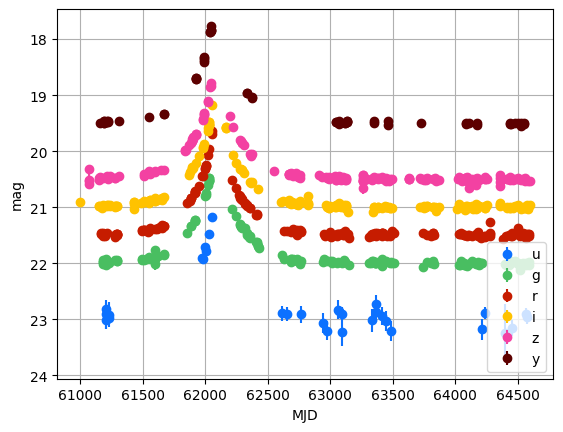

In [18]:
# It is time to plot our event
def flux_to_mag_df(df):
    df = df.copy()
    df = df.query("flux > 0")
    df["mag"] = flux2mag(df["flux"])
    df["magerr"] = 2.5 / np.log(10) * df["fluxerr"] / df["flux"]
    df["band"] = df["filter"]
    return df

COLORS = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
    "zg": "#62D03E",
    "zr": "#CC3344",
}


def plot_lc(df, period=None):
    df = df.copy()
    if period is not None and "phase" not in df.columns:
        mjd_min_light = df["mjd"][df.query("band == 'r'")["mag"].idxmax()]
        df["phase"] = (df["mjd"] - mjd_min_light) % period / period
    if period is None:
        x_col = "mjd"
    else:
        x_col = "phase"
    plt.figure()
    if len({"zg", "zr"} & set(df["band"])) > 0:
        for band in ["zg", "zr"]:
            data = df.query("band == @band")
            plt.errorbar(
                data[x_col],
                data["mag"],
                yerr=data["magerr"],
                label=f"{band}",
                fmt="o",
                color=COLORS[band],
                alpha=0.2,
            )
    for band in "ugrizy":
        data = df.query("band == @band")
        plt.errorbar(
            data[x_col], data["mag"], yerr=data["magerr"], label=f"{band}", fmt="o", color=COLORS[band]
        )

    plt.gca().invert_yaxis()
    if period is None:
        plt.xlabel("MJD")
    else:
        plt.xlabel("phase")
        plt.xlim([0, 1])
        plt.title(f"{period = } d")
    plt.ylabel("mag")
    plt.legend(loc="lower right")
    plt.grid(True)
    # plt.ylim(30, 0)
    
mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)